# **Project: Disease detection from Chest X-Ray**

### **Project Goal:**
Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

### **Dataset:**
Chest X-Ray Images (Pneumonia) – Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 5,863 total images across training, test, and validation folders
- Two classes: NORMAL, PNEUMONIA


### **1. Problem Understanding**

**What are you actually solving?**

- Binary classification: Normal vs Pneumonia

- Input: Chest X-ray images

- Output: A probability or class label

**Key mindset shift:**

- This is decision support, not diagnosis

- False negatives (missing pneumonia) are often more dangerous than false positives



In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

train_images = keras.utils.image_dataset_from_directory('data/train')

val_images = keras.utils.image_dataset_from_directory('data/val')

test_images = keras.utils.image_dataset_from_directory('data/test')

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


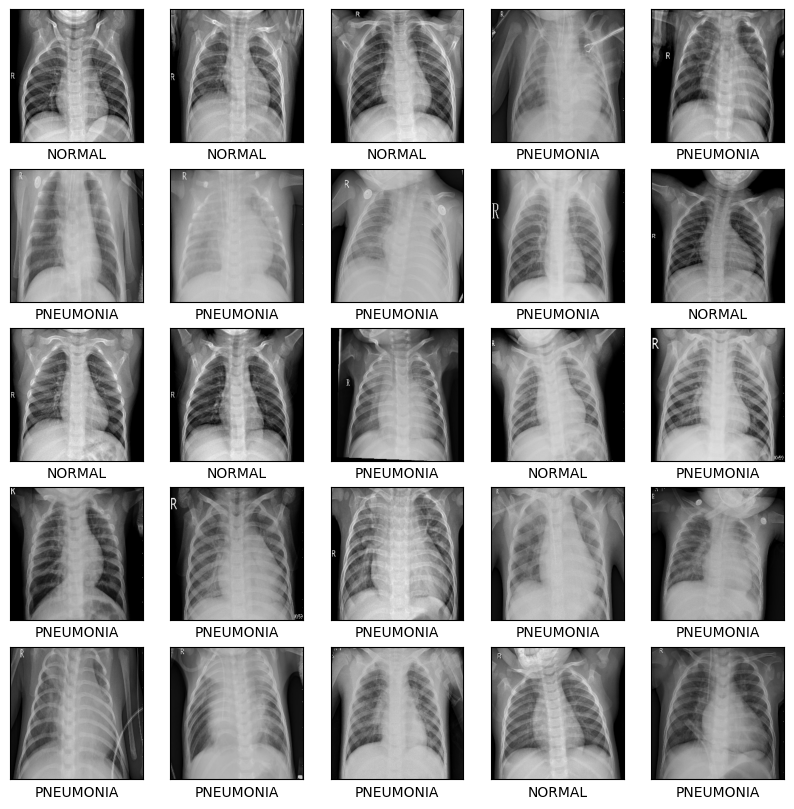

In [ ]:
class_names = train_images.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_images.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i].numpy().astype("uint8"))

        label = labels[i]
        if len(label.shape) > 0: 
            label_index = tf.argmax(label).numpy()
        else:
            label_index = label.numpy()

        plt.xlabel(class_names[label_index])

In [ ]:
# understand the data structure 
for images, labels in train_images.take(1):
    print(images.shape) # (batch_size, height, width, channels)
    print(labels.shape) # (batch_size, ) 

# count the number of NORMAL and PNEUMONIA images in the training set
normal_count = 0
pneumonia_count = 0
for images, labels in train_images:
    normal_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    pneumonia_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()
print(f"Total NORMAL images in training set: {normal_count}")
print(f"Total PNEUMONIA images in training set: {pneumonia_count}")


(32, 256, 256, 3)
(32,)
Total NORMAL images in training set: 1341
Total PNEUMONIA images in training set: 3875


### Conclusion: Imbalanced dataset:

Based on the output, we can calculate the Class Distribution:
- Total Images: 1341 + 3875 = 5216
- Pneumonia : (3875 / 5216) * 100 ~ 74.3%
- Normal: (1341 / 5216) * 100 ~ 25.7%
We have nearly 3 times more Pneumonia cases than Normal cases. This is considered a **moderate to severe imbalance.**


**Effects on the model:**
If I were to train your model right now without addressing this, the following would likely happen:

- **The "Lazy" Model**: The model would achieve 74% accuracy by simply guessing "Pneumonia" every single time without even looking at the image pixels.

- **High False Positives:** The model will be biased toward finding disease. It might see a slight shadow in a healthy lung and immediately label it "Pneumonia" because it "expects" that class more often.

- **Misleading Accuracy:** You might feel proud of an 85% accuracy score, but if you check the Recall for the "Normal" class, it might be very low (meaning the model is failing to identify healthy people correctly).


**How to fix this issue:**
the easiest way to fix this during training is using **Class Weights**. This tells the loss function to penalize mistakes on "Normal" images more heavily than mistakes on "Pneumonia" images. We add this logic before model.fit

**But first, we have to resize the images, normalize and augment before building the model layers and fit**

In [ ]:
IMAGE_SIZE = (224, 224)  # resize images to 224x224
BATCH_SIZE = 32  

train_images = keras.utils.image_dataset_from_directory(
    'data/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

val_images = keras.utils.image_dataset_from_directory(
    'data/val',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

test_images = keras.utils.image_dataset_from_directory(
    'data/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


> **label_mode="binary"**

- Because this is Normal vs Pneumonia

- Outputs labels as 0/1

- Matches binary classification loss later

> **shuffle=False** for val/test

- Ensures consistent evaluation

- Prevents confusion matrix mismatches



In [40]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

train_images = train_images.map(normalize_img)
val_images = val_images.map(normalize_img)
test_images = test_images.map(normalize_img)

In [42]:
# data augmentation to reduce overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [43]:
model = tf.keras.Sequential([
    data_augmentation, # apply data augmentation
    # CNN layers
    # layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    # layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])



/Users/naghamhabli/Desktop/the ai engineering/chestXray/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
